In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

# Generate Dataset
## $y=x+0.3\sin(2\pi x)+\epsilon$

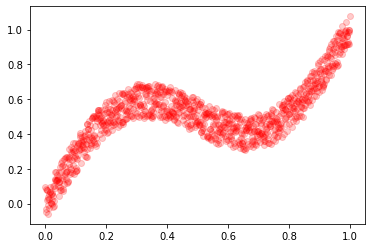

In [2]:
x = torch.linspace(0, 1, 1000)
epsilon = torch.FloatTensor(1000).uniform_(-0.1, 0.1)
y = x + 0.3 * torch.sin(2*math.pi*x) + epsilon
plt.plot(x,y,'ro',alpha=0.2)

## Use a simple neural network to fit it

In [3]:
net = nn.Sequential(
    nn.Linear(1, 5),
    nn.Tanh(),
    nn.Linear(5, 1),
)
net_predict = lambda a: net(a.unsqueeze(1)).squeeze()

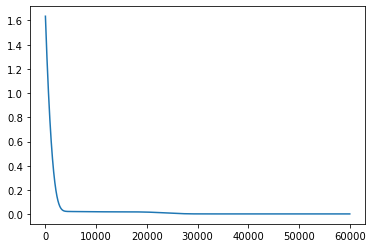

In [4]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
losses = []
for epoch in range(60000):
    optimizer.zero_grad()
    y_hat = net_predict(x)
    loss = torch.mean((y-y_hat)**2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)

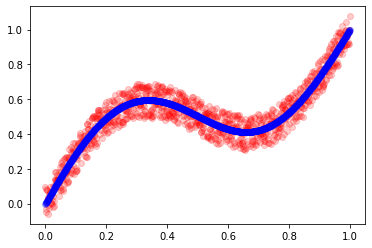

In [5]:
plt.plot(x,y,'ro',alpha=0.2)
plt.plot(x,net_predict(x).detach(), 'bo',alpha=0.3)

# Now we relpace $x$ and $y$ with each other

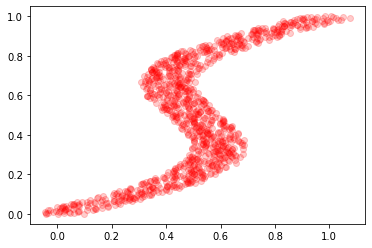

In [6]:
x = torch.linspace(0, 1, 1000)
epsilon = torch.FloatTensor(1000).uniform_(-0.1, 0.1)
y = x + 0.3 * torch.sin(2*math.pi*x) + epsilon
x, y = y, x
plt.plot(x,y,'ro',alpha=0.2)

In [7]:
net = nn.Sequential(
    nn.Linear(1, 5),
    nn.Tanh(),
    nn.Linear(5, 1),
)
predict = lambda a: net(a.unsqueeze(1)).squeeze()

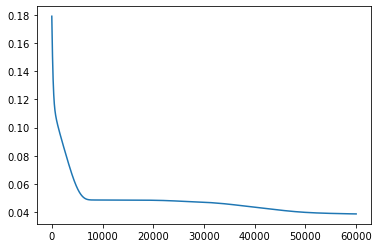

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
losses = []
for epoch in range(100000):
    optimizer.zero_grad()
    y_hat = predict(x)
    loss = torch.mean((y-y_hat)**2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)

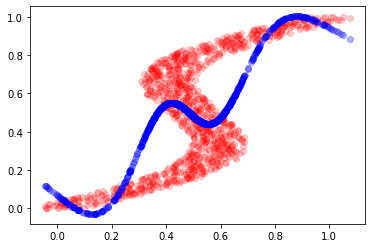

In [9]:
plt.plot(x,y,'ro',alpha=0.2)
plt.plot(x,predict(x).detach(), 'bo',alpha=0.3)

## The network fits badly because the conditional average is not the answer any more.

# Mixture Density Networks

In [65]:
class Net(nn.Module):
    def __init__(self, num_gaussian=6, num_hidden=16):
        super().__init__()
        self.gen_feature = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.Tanh(),
            )
        self.mu = nn.Linear(num_hidden, num_gaussian)
        self.sigma = nn.Linear(num_hidden, num_gaussian)
        self.alpha = nn.Sequential(
            nn.Linear(num_hidden, num_gaussian),
            nn.Softmax(dim=1),
            )

    def forward(self, x):
        feature = self.gen_feature(x.unsqueeze(1)) 
        return self.mu(feature), self.sigma(feature).exp(), self.alpha(feature)

num_gaussian=6
num_hidden=16 
net = Net(num_gaussian=num_gaussian, num_hidden=num_hidden)

In [66]:
def loss_func(mu_hat, sigma_hat, alpha_hat, y):
    phi = 1 / sigma_hat * torch.exp( - (mu_hat-y.unsqueeze(1))**2 / sigma_hat**2 / 2 )
    return (-torch.log((alpha_hat*phi).sum(dim=1))).sum()

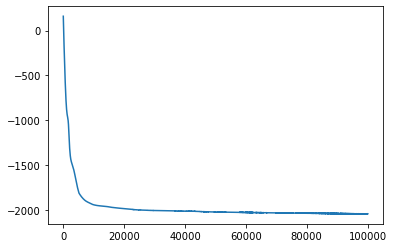

In [67]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
losses = []
for epoch in range(100000):
    optimizer.zero_grad()
    mu_hat, sigma_hat, alpha_hat = net(x)
    loss = loss_func(mu_hat, sigma_hat, alpha_hat, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)

## If we plot the $\sum_{i=1}^m\alpha_i\mu_i$

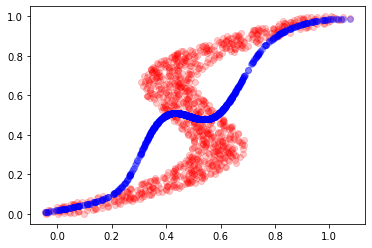

In [68]:
plt.plot(x,y,'ro',alpha=0.2)
mu, sigma, alpha = net(x)
plt.plot(x, (alpha*mu).sum(dim=1).detach(), 'bo',alpha=0.3)

Note that it is exactly what we got from the traditional neural network, i.e., conditonal average.

## If we just plot the mean:

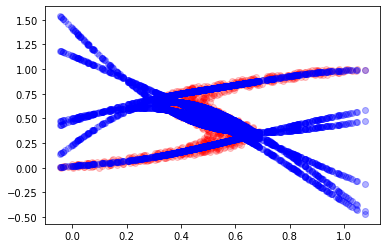

In [69]:
plt.plot(x,y,'ro',alpha=0.2)
for i in range(num_gaussian):
    plt.plot(x, net(x)[0][:, i].detach(), 'bo',alpha=0.3)

## If we do sampling according to the weights $\phi_i$

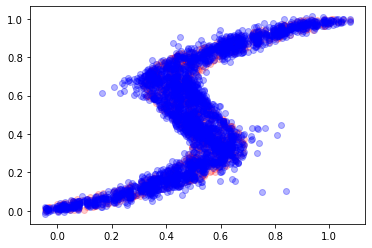

In [92]:
def sample(mu, sigma, alpha, n_points=1):
    sampled_examples = torch.zeros(mu.shape[0], n_points)
    for i_ in range(mu.shape[0]):
        sampled_idx = torch.multinomial(alpha[i_], num_samples=n_points, replacement=True)
        sampled_examples[i_] = mu[i_, sampled_idx] + sigma[i_, sampled_idx] * torch.randn_like(mu[i_, sampled_idx])
    return sampled_examples

n_points = 3
mu, sigma, alpha = net(x)
sampled_examples = sample(mu, sigma, alpha, n_points=n_points)

plt.plot(x,y,'ro',alpha=0.2)
for i in range(n_points):
    plt.plot(x, sampled_examples[:, i].detach(), 'bo',alpha=0.3)

## We can also either choose $\max_i \alpha_i$ or $\max_i\frac{\alpha_i}{\sigma_i}$ to get the most possible prediction (as suggested by the paper)

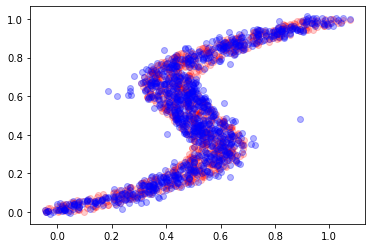

In [96]:
def predict(mu, sigma, alpha):
    sampled_examples = torch.zeros(mu.shape[0], n_points)
    for i_ in range(mu.shape[0]):
#         sampled_idx = (alpha[i_]/sigma[i_]**2).max()[1]
        sampled_idx = (alpha[i_]).max()[1]
        sampled_examples[i_] = mu[i_, sampled_idx]
    return sampled_examples.squeeze()

mu, sigma, alpha = net(x)
sampled_examples = sample(mu, sigma, alpha)

plt.plot(x,y,'ro',alpha=0.2)
plt.plot(x, sampled_examples.detach(), 'bo',alpha=0.3)